# Point Net Segmentation

This notebook will explore the Segmentation head of Point Net using the reduced and paritioned version of S3DIS dataset. This version is similar to the one used by torch geometry except that we will have to normalize and sample data on the fly. We also choose to use larger paritions that the 1x1m ones used in PointNet, we choose the larger partitions since it gives the model a greater chance to learn the overall strcutures of each class.

#### **Current State: Mildly Chaotic**

#### TODO:
- ensure that everything else is organized
- Continue training and testing
- Add descriptive analytics for dataset to help with understanding and training
- Add intuitive explainations and theory as needed

TEMP NOTE

use "git reset HEAD~1" to go back one commit

https://stackoverflow.com/questions/20002557/how-to-remove-a-too-large-file-in-a-commit-when-my-branch-is-ahead-of-master-by

In [1]:
import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

Initialize variables for entire notebook

In [33]:
# dataset
ROOT = r'C:\Users\itber\Documents\datasets\S3DIS\Stanford3dDataset_v1.2_Reduced_Partitioned_Aligned_Version_1m'

# feature selection hyperparameters
NUM_TRAIN_POINTS = 4096 # train/valid points
NUM_TEST_POINTS = 15000

BATCH_SIZE = 16

See: https://www.mathworks.com/help/vision/ug/point-cloud-classification-using-pointnet-deep-learning.html

In [8]:
CATEGORIES = {
    'ceiling'  : 0, 
    'floor'    : 1, 
    'wall'     : 2, 
    'beam'     : 3, 
    'column'   : 4, 
    'window'   : 5,
    'door'     : 6, 
    'table'    : 7, 
    'chair'    : 8, 
    'sofa'     : 9, 
    'bookcase' : 10, 
    'board'    : 11,
    'stairs'   : 12,
    'clutter'  : 13
}

# unique color map generated via
# https://mokole.com/palette.html
COLOR_MAP = {
    0  : (47, 79, 79),    # ceiling - darkslategray
    1  : (139, 69, 19),   # floor - saddlebrown
    2  : (34, 139, 34),   # wall - forestgreen
    3  : (75, 0, 130),    # beam - indigo
    4  : (255, 0, 0),     # column - red 
    5  : (255, 255, 0),   # window - yellow
    6  : (0, 255, 0),     # door - lime
    7  : (0, 255, 255),   # table - aqua
    8  : (0, 0, 255),     # chair - blue
    9  : (255, 0, 255),   # sofa - fuchsia
    10 : (238, 232, 170), # bookcase - palegoldenrod
    11 : (100, 149, 237), # board - cornflower
    12 : (255, 105, 180), # stairs - hotpink
    13 : (0, 0, 0)        # clutter - black
}

v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])

NUM_CLASSES = len(CATEGORIES)

#### Get Datasets and Dataloaders

In [9]:
from torch.utils.data import DataLoader
from s3dis_dataset import S3DIS

# get datasets
s3dis_train = S3DIS(ROOT, area_nums='1-4', npoints=NUM_TRAIN_POINTS)
s3dis_valid = S3DIS(ROOT, area_nums='5', npoints=NUM_TRAIN_POINTS)
s3dis_test = S3DIS(ROOT, area_nums='6', split='test', npoints=NUM_TEST_POINTS)

# get dataloaders
train_dataloader = DataLoader(s3dis_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(s3dis_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(s3dis_test, batch_size=BATCH_SIZE, shuffle=False)

Get an example and display it

In [10]:
points, targets = s3dis_train[10]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets)).T/255)

# draw(pcd)
o3.visualization.draw_plotly([pcd])

#### Investigate class distributions in the Training dataset

NOTE: If you take a look at the S3DIS dataset class, you will notice that samples with less points than npoints are sampled with replacement. This means that some points will be oversampled. This will lead to a variable class balance eachtime the dataloader is called. However, you can run these cells many times and see that we will nearly always have the same ratios of classes.

In [17]:
total_train_targets = []
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

Plot Barchart of category counts

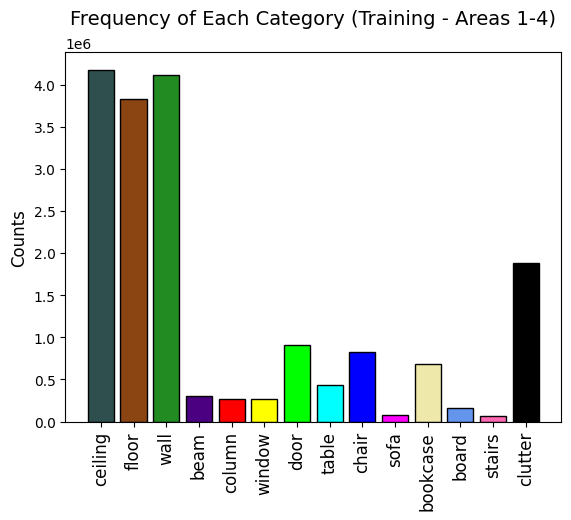

In [8]:
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=[np.array(val)/255. for val in list(COLOR_MAP.values())],
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Frequency of Each Category (Training - Areas 1-4)', size=14, pad=20);

We can see that this dataset is heavily imbalanced, the more common items such as ceiling, floor, and wall greatly outnumber all of the other categories. These classes are actually background classes. If we were to train using a loss such as Cross Entropy, we would consider each class to have an equal importance. Meaning, missclassifyng window is treated the same as misclassifying wall. In reality, we would want our model to focus more on the uncommon categories and not care so much about the common ones. We have a priori knowledge that structures such as ceiling, wall, and floor are continuous and if we look at some training examples, we will see that they are like large sheets. If we were to only classify 60% of these, we would still be in pretty good shape. However, if we classify only 60% of the other less common classes, we may run into some serious generalization issues. One way to overcome the class imbalance is to use a weighted loss function. This will essentially tell the model (during training) to focus more on particular classes that it gets wrong (hard examples) and to focus less on the classes it tends to get right (easy examples).

*SIDE NOTE:*
*With the notion that certain classes have unique structures, it may be more effective to perform object recognition as opposed to segmentation. Or use some sort of object recognition to augment the segmentation model and form some sort of ensemble.*

The loss that we will use is called the [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf), it is a modified version of the Cross Entropy (CE) loss that is useful for imbalanced classification, it focuses the training on a sparse set of hard examples. 

We will also try to use the [Dice Loss](https://arxiv.org/pdf/1707.03237v3.pdf) and compare results.

Also see this [paper](https://www.sciencedirect.com/science/article/pii/S2590005619300049#bib72) for Dice Loss

#### Focal Loss Notes:
- it focuses training on a sparse set of hard examples
- Predictions with Probability >> 0.5 are easy examples and they should not have a high loss
   - This is because summing the losses of many easy examples will quickly overwhelm the loss of the few hard examples
-

### Loss Function approach

Since this data set is heavily imbalanced we could try approaches such as Balanced Cross Entropy which weights example importance according to class distribution or the Focal Loss which forces the model to focus on more difficult examples (i.e. ones predicted with a low probability). These approaches are effective for classification, but we want to go a bit further in this segmentation problem. We know that the structures are continuous and that points of a certain class are likely to contain other points in the same class within close proximity. We use the approaches in this [paper](https://arxiv.org/pdf/1810.01151.pdf) to incorporate pairwaise distance loss and centroid loss functions into our approach

### Get Segmentation Version of Point Net
Make a test forward pass

In [11]:
from point_net import PointNetSegHead

points, targets = next(iter(train_dataloader))

seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES)
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([16, 8192, 14])


## Start Training

In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

Compute $\alpha$ as the normalized inverse class frequency.

Instead compute alpha roughly based on class frequencies

Load model from disk if necessary

In [13]:
# MODEL_PATH = 'seg_balanced/seg_model_15.pth'

# seg_model = PointNetSegHead(num_points=NUM_TRAIN_POINTS, m=NUM_CLASSES).to(DEVICE)
# seg_model.load_state_dict(torch.load(MODEL_PATH))

Training hyperparameters

In [14]:
import torch.optim as optim
from point_net_loss import PointNetLoss

EPOCHS = 50
LR = 0.0001
REG_WEIGHT = 0.

# use inverse class weighting
# alpha = 1 / class_bins
# alpha = (alpha/alpha.max())

# manually set alpha weights
alpha = np.ones(len(CATEGORIES))
alpha[0:3] *= 0.25 # balance background classes
alpha[-1] *= 0.75  # balance clutter class

gamma = 1

optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, 
                                              step_size_up=2000, cycle_momentum=False)
criterion = PointNetLoss(alpha=alpha, gamma=gamma, reg_weight=REG_WEIGHT).to(DEVICE)

seg_model = seg_model.to(DEVICE)

For our training we will want to quantify how well our model is performing. Typically we look at loss and accuracy, but for this segmentation problem we will need a metric that accounts for incorrect classification as well as correct classification. The Matthews Correlation Coefficient does this and we will use it to quantify our performance. The MCC ranges from -1 to 1, to understand what the MCC is reporting:
- 0 indicates a random guess
- -1 is the worst possible performance
- 1 is the best possible performance

In [15]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

NOTE: In the original TensorFlow implementation, the regularization term is not used to train the sematic segmentation model.

In [19]:
# stuff for training
num_train_batch = int(np.ceil(len(s3dis_train)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(s3dis_valid)/BATCH_SIZE))

# store best validation mcc
best_mcc = 0. # -np.infty

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
valid_loss = []
valid_accuracy = []
valid_mcc = []

for epoch in range(16, EPOCHS + 22):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    for i, (points, targets) in enumerate(train_dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = seg_model(points)

        # get loss and perform backprop
        loss = criterion(preds.transpose(2, 1), targets, A) # + REG_FACTOR*reg/preds.size(0)
        loss.backward()
        optimizer.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        for i, (points, targets) in enumerate(valid_dataloader, 0):

            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.squeeze().to(DEVICE)

            preds, _, A = seg_model(points)

            loss = criterion(preds.transpose(2, 1), targets) 

            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
            mcc = mcc_metric(preds.transpose(2, 1), targets)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())

            if i % 100 == 0:
                print(f'\t [{epoch}: {i}/{num_valid_batch}] ' \
                  + f'valid loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        print(f'Epoch: {epoch} - Validation Loss: {valid_loss[-1]:.4f} ' \
              + f'- Validation Accuracy: {valid_accuracy[-1]:.4f} ' \
              + f'- Validation MCC: {valid_mcc[-1]:.4f}')

        # pause to cool down
        time.sleep(4)

    # save best models
    if valid_mcc[-1] >= best_mcc:
        best_mcc = valid_mcc[-1]
        torch.save(seg_model.state_dict(), f'trained_models/seg_focal/seg_model_{epoch}.pth')

	 [16: 0/275] train loss: 2.6542 accuracy: 0.0561 mcc: 0.0043
	 [16: 100/275] train loss: 2.1998 accuracy: 0.2511 mcc: 0.1493
	 [16: 200/275] train loss: 1.8271 accuracy: 0.4070 mcc: 0.2918
Epoch: 16 - Train Loss: 2.0001 - Train Accuracy: 0.3101 - Train MCC: 0.2051
	 [16: 0/146] valid loss: 4.9815 accuracy: 0.3479 mcc: 0.2182
	 [16: 100/146] valid loss: 2.1217 accuracy: 0.4628 mcc: 0.3448
Epoch: 16 - Validation Loss: 3.9704 - Validation Accuracy: 0.4878 - Validation MCC: 0.3679
	 [17: 0/275] train loss: 1.5835 accuracy: 0.4380 mcc: 0.3280
	 [17: 100/275] train loss: 1.5195 accuracy: 0.4911 mcc: 0.3721
	 [17: 200/275] train loss: 1.6775 accuracy: 0.4511 mcc: 0.3231
Epoch: 17 - Train Loss: 1.2552 - Train Accuracy: 0.5446 - Train MCC: 0.4409
	 [17: 0/146] valid loss: 1.2563 accuracy: 0.5132 mcc: 0.3964
	 [17: 100/146] valid loss: 0.7949 accuracy: 0.6055 mcc: 0.5062
Epoch: 17 - Validation Loss: 1.3075 - Validation Accuracy: 0.5613 - Validation MCC: 0.4609
	 [18: 0/275] train loss: 1.0710 a

Let's plot the training metrics

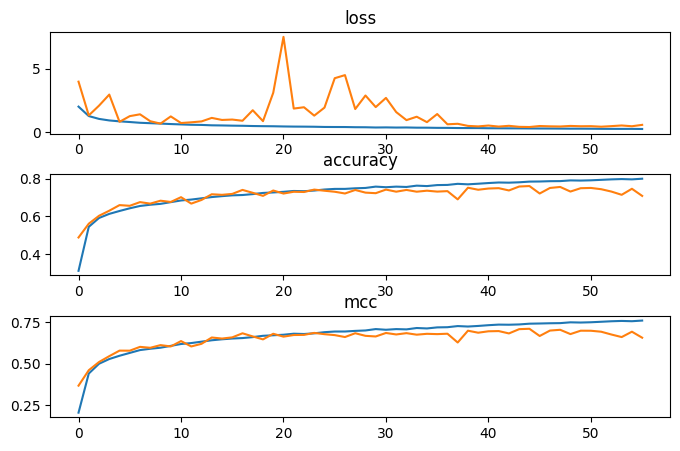

In [25]:
_, ax = plt.subplots(3, 1, figsize=(8, 5))
ax[0].plot(train_loss)
ax[0].plot(valid_loss)
ax[0].set_title('loss')

ax[1].plot(train_accuracy)
ax[1].plot(valid_accuracy)
ax[1].set_title('accuracy')

ax[2].plot(train_mcc)
ax[2].plot(valid_mcc)
ax[2].set_title('mcc')

plt.subplots_adjust(wspace=0., hspace=0.4)

### Test the model

Upload model from disk. The best model was 21 (actually 22 since we need to account for zero indexing)

In [16]:
MODEL_PATH = 'trained_models/seg_focal/seg_model_60.pth'

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

#### Implement Quick test to gather metrics

In [ ]:
num_test_batch = int(np.ceil(len(s3dis_test)/BATCH_SIZE))

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    for i, (points, targets) in enumerate(test_dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        preds, _, A = model(points)

        loss = criterion(preds.transpose(2, 1), targets)

        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_valid_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')

In [31]:
# display test results
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f}')

Test Loss: 0.4479 - Test Accuracy: 0.7449 - Test MCC: 0.7001


In [32]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

#### Get Confusion Matrix for Test data

In [33]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(CATEGORIES.keys()),
                              index=list(CATEGORIES.keys()))

test_confusion

,ceiling,floor,wall,beam,column,window,door,table,chair,sofa,bookcase,board,stairs,clutter
ceiling,2414492,3454,40568,2510,529,2428,1584,0,0,11,899,36,806,34258
floor,6949,2156440,6784,0,0,47,2701,85,3065,0,1411,0,7452,3257
wall,50699,24893,1705978,41072,26800,53614,207259,6269,1120,99,112254,25686,6644,151839
beam,50852,0,47376,290042,509,0,26947,0,0,0,2355,0,101,49765
column,1880,9291,108897,2206,43599,503,70879,126,846,6,31999,1069,1115,56143
window,748,15,40678,4074,155,182486,0,6,0,0,2188,1499,0,3624
door,159,12134,93308,32086,1390,0,390462,743,1342,0,24308,11,286,53100
table,0,12953,17528,0,498,393,1412,295914,59349,872,18968,0,392,110100
chair,0,27684,2659,0,0,35,7419,63960,292781,4016,7438,259,97,34532
sofa,0,5730,549,0,0,0,193,3551,16592,6500,1289,7,126,13512


#### View test results on full space

In [18]:
def compute_iou(targets, predictions):
    ''' Computes IOU metric for multiclass predictions '''
    targets = targets.reshape(-1)
    predictions = pred_choice.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets)

    print(intersection/len(predictions))

    return intersection / (union - intersection)


def dice_loss(targets, predictions, eps=1):

    targets = targets.reshape(-1)
    predictions = pred_choice.reshape(-1)

    cats = torch.unique(targets)

    top = 0
    bot = 0
    for i, c in enumerate(cats):
        locs = targets == c

        # get truth and predictions for each class
        y_tru = targets[locs]
        y_hat = predictions[locs]

        top += torch.sum(y_hat == y_tru)
        bot += torch.sum(y_hat == y_tru) + len(y_hat)


    return 1 - 2*((top + eps)/(bot + eps))

    

In [20]:
compute_iou(targets, pred_choice)

tensor(0.7878, device='cuda:0')


tensor(0.6499, device='cuda:0')

In [98]:
dice_loss(targets, pred_choice, eps=1)

tensor(0.7889, device='cuda:0')

In [163]:
# reshape points
points = norm_points.permute(2, 0, 1).reshape(-1, 3)
points.shape

torch.Size([240000, 3])

In [19]:
torch.cuda.empty_cache() # release GPU memory
points, targets = s3dis_test.get_random_partitioned_space()

# place on device
points = points.to(DEVICE)
targets = targets.to(DEVICE)

# Normalize each partitioned Point Cloud to (0, 1)
norm_points = points.clone()
norm_points = norm_points - norm_points.min(axis=1)[0].unsqueeze(1)
norm_points /= norm_points.max(axis=1)[0].unsqueeze(1)

with torch.no_grad():

    norm_points = norm_points.transpose(2, 1)
    targets = targets.squeeze()

    preds, _, A = model(norm_points)

    pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)
    correct = pred_choice.eq(targets.data).cpu().sum()
    accuracy = correct/float(points.shape[0]*NUM_TEST_POINTS)
    mcc = mcc_metric(preds.transpose(2, 1), targets)

print(f'Accuracy: {accuracy} - MCC: {mcc}')

Accuracy: 0.7878111004829407 - MCC: 0.7539854645729065


Display the truth and predictions

In [21]:
# display true full point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_0')

In [25]:
# display true partitioned point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[0, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(targets.to('cpu')[0, :])).T/255)

draw(pcd)

WebVisualizer(window_uid='window_4')

In [22]:
# display predicted full point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.permute(2, 0, 1).reshape(3, -1).to('cpu').T)
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.reshape(-1).to('cpu'))).T/255)

draw(pcd)

WebVisualizer(window_uid='window_1')

In [24]:
# display predicted partitioned point cloud
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points.to('cpu')[0, :, :])
pcd.colors = o3.utility.Vector3dVector(np.vstack(v_map_colors(pred_choice.to('cpu')[0, :])).T/255)

draw(pcd)

WebVisualizer(window_uid='window_3')

### General Notes

It appears that not using the regularized loss leads to quicker training i.e. better performance with less epochs. Some more experimentation could be done to check if the regularization leads to superior performance over a longer training period.

It seems like the regularization term in the loss function greatly overpowers the loss. Causing the loss to blow up.